# MCCFindNet Demo

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import json
import caffe
import scipy.misc

from cffi import FFI
from sys import exit, platform
import cv2

import PIL.Image as Image
import PIL.ImageColor as ImageColor
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont

import detectlib.utils as utl
import detectlib.visualizationutl as view
import detectlib.imageutl as imutl
import detectlib.netutility as netutl

import colorchecker
import utils


%matplotlib inline

In [2]:
bSHOW = False
bDRAWCAM = True
bIMGSALVE = True
bJSON = False
bGPU = False
bWEBCAM = False  # use webcam True or False for video
CAMDEVICE = 0  # or camera device number
pathconfigurate = 'detection.json';
pad = 40

# load configurate
config = netutl.loadconfig( pathconfigurate );
modelpath  = str(config['netpath']);
modelproto = str(config['netproto']);    
modelcaffe = str(config['netmodel']);
imagesize = config['image_dimensions'];


netpath : models/detection
caffe version : 0.15.13
netmodel : model.caffemodel
framework : caffe
caffe flavor : NVIDIA
image_dimensions : [640, 1024, 3]
netname : detectnet
camara device : 0
netproto : deploy.prototxt


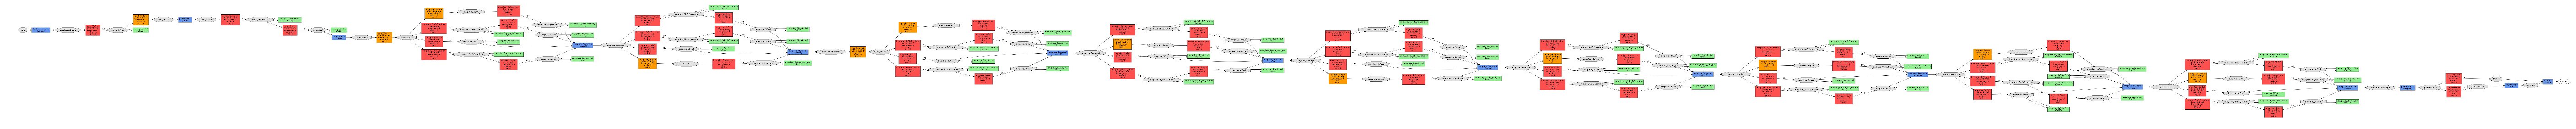

In [3]:
from google.protobuf import text_format
import caffe.draw
from caffe.proto import caffe_pb2

nnet = caffe_pb2.NetParameter();
text_format.Merge( open( os.path.join(modelpath,modelproto) ).read(), nnet);
caffe.draw.draw_net_to_file(nnet, 'detectnet.png', 'LR');

image_net = Image.open('detectnet.png');
image_net.load();

fig = plt.figure(figsize=(100, 100))
plt.imshow(image_net);
plt.axis('off')
plt.show();

## Image read

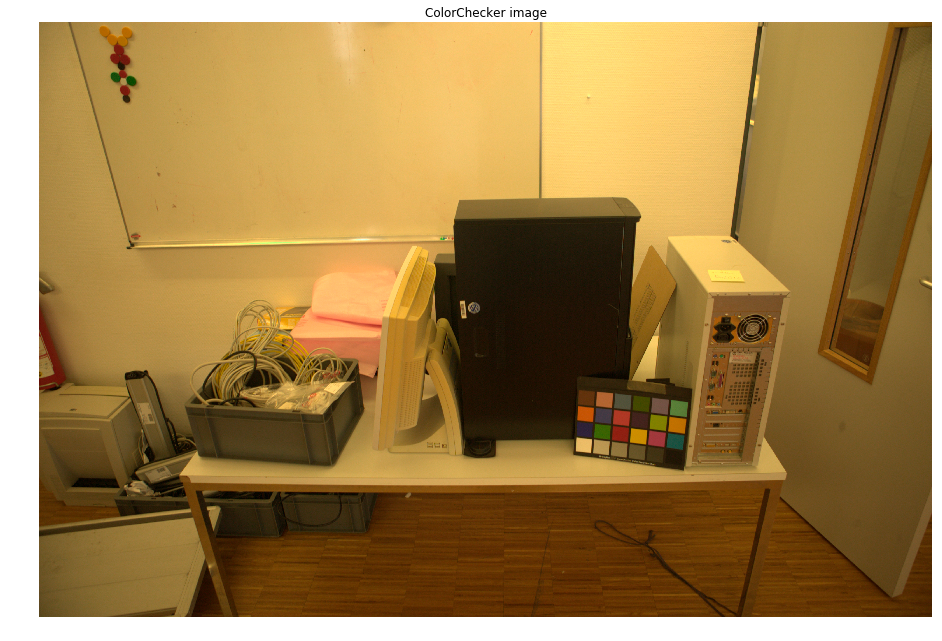

In [3]:

image = cv2.imread('rec/000003.png')[:,:,(2,1,0)]

plt.figure( figsize=(16,12) )
plt.imshow(image)
plt.title('ColorChecker image')
plt.axis('off')
plt.show()


## ColorChecker Localization

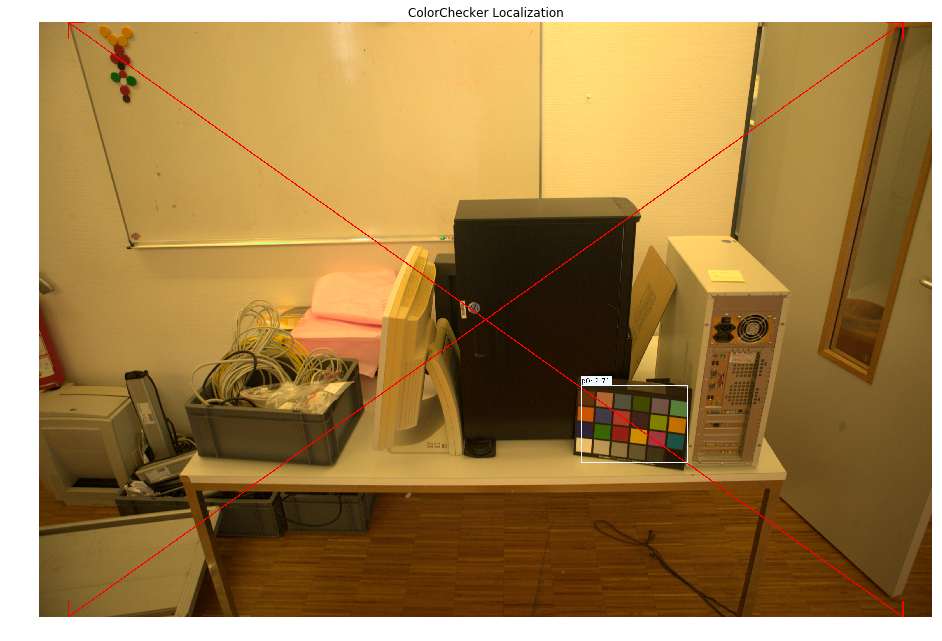

CPU times: user 15.2 s, sys: 6.15 s, total: 21.3 s
Wall time: 15.6 s


In [4]:
%%time

# create detection filter
det = netutl.cDetectionNet(modelpath, modelproto, modelcaffe);
det.create();

# process
det.process(image);

# draw camera
image_output = view.plotcameracv(image, det.vbox);

# draw bbox
ccc = det.colorcheckers;
netutl.draw_all(image_output, ccc);

plt.figure( figsize=(16,12) )
plt.imshow(image_output);
plt.title('ColorChecker Localization')
plt.axis('off')
plt.show();



## Path color checker recognition

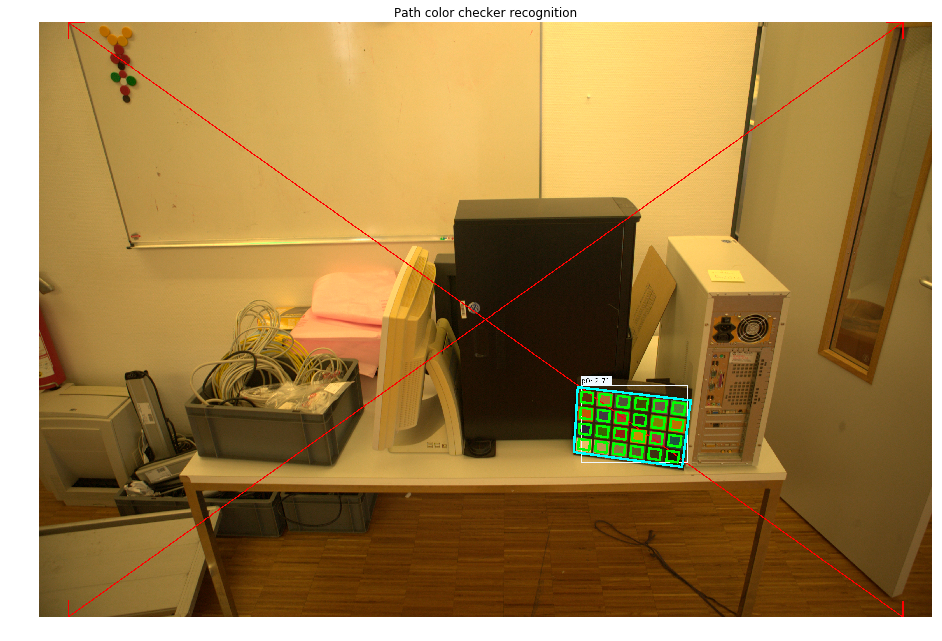

CPU times: user 2.44 s, sys: 262 ms, total: 2.7 s
Wall time: 2.86 s


In [5]:
%%time

paths = utils.selected_image_paths( image, ccc, pad )        
if len(paths) == 0:
    print('Not detection colorchecker ')
    
imagepath, left, top = paths[0]
box = colorchecker.find( imagepath[:,:,(2,1,0)] )

# res-localitation
box[:,0] = box[:,0]+left
box[:,1] = box[:,1]+top

image_output = view.plotpolycv( image_output, box )
image_output = view.drawcolorchecker(image_output, box, [0,255,0])

plt.figure( figsize=(16,12) )
# plt.imshow( image[:,:,(2,1,0)] )
plt.imshow( image_output )
#plotbbox(box)
#plt.plot( box[:,0], box[:,1] , 'o' )
#plt.plot( box[0,0], box[0,1] , 'rs' )
plt.title('Path color checker recognition')
plt.axis('off')
plt.show()



In [18]:
# video color checker recognition

In [17]:
import cv2 
from IPython.display import clear_output

filename = 'db/mcc.mp4'
cap = cv2.VideoCapture( filename )

# create detection filter
det = netutl.cDetectionNet(modelpath, modelproto, modelcaffe);
det.create();

print(cap.isOpened())

iter = 0;
# for every frame
while(cap.isOpened()):
    
    # read
    for i in range(50): 
        ret, frame = cap.read();
    
    # step 1
    # localization 
    # process
    det.process( frame );
    
    # draw camera
    image_output = view.plotcameracv(frame, det.vbox);

    # draw bbox
    ccc = det.colorcheckers;
    netutl.draw_all(image_output, ccc);
    
    
    # step 2
    # recognition 
    paths = utils.selected_image_paths( frame, ccc, pad )        
    if len(paths) == 0:
        print('Not detection colorchecker ')
        continue
        
    imagepath, left, top = paths[0]
    
    box = colorchecker.find( imagepath[:,:,(2,1,0)] )
    
    # res-localitation
    box[:,0] = box[:,0]+left
    box[:,1] = box[:,1]+top
    
    # draw box
    image_output = view.plotpolycv( image_output, box )
    image_output = view.drawcolorchecker(image_output, box, [0,255,0])
    

    # write
    #det.writejson('pieces.json');
    
    # write frame 
    cv2.imwrite('out/{:06d}.png'.format(i), image_output)
    
    # show
    plt.imshow(image_output[:,:,(2,1,0)]);
    plt.show();
    clear_output(wait=True) 
    
    iter += 1;
    break;
    
    
cap.release()


False


In [ ]:
import cv2 
from IPython.display import clear_output

bshow=False
filename = 'db/video'
data = imutl.imageProvide(filename,'png');

# create detection filter
det = netutl.cDetectionNet(modelpath, modelproto, modelcaffe);
det.create();


k = 0;
# for every frame
for i in range( data.num ): 
        
    frame = data.getimage(i)
    
    # Step 1: localization 
    # process
    det.process( frame[:,:,(2,1,0)] );
    
    # draw camera
    image_output = view.plotcameracv(frame, det.vbox);

    # draw bbox
    ccc = det.colorcheckers;
    netutl.draw_all(image_output, ccc);
    
    
    # Step 2: recognition 
    
    paths = utils.selected_image_paths( frame, ccc, pad )      
    for  (imagepath, left, top) in paths:
        try:                
            box = colorchecker.find( imagepath[:,:,(2,1,0)] )
            # res-localitation
            box[:,0] = box[:,0]+left
            box[:,1] = box[:,1]+top
        except:
            print('Not recognition path colorchecker in iter {} '.format(k));

        # draw box
        if box.sum() != 0:                   
            image_output = view.plotpolycv( image_output, box, thickness=4 )
            image_output = view.drawcolorchecker(image_output, box, [0,255,0], thickness=4)

    if bshow:    
        # show
        plt.imshow(image_output);
        plt.plot( box[0,0], box[0,1] , 'rs' )
        plt.title('{}'.format(k))
        plt.axis('off')
        plt.show(); 
        clear_output(wait=True) 
    
    
    # write frame 
    cv2.imwrite('out/{:06d}.png'.format(k), image_output[:,:,(2,1,0)] )
       
    #print(k)
    
    k += 1;
    #break;
    
    
